(32, 32, 32)


/tmp/ipykernel_7793/1850576547.py:49: RuntimeWarning: divide by zero encountered in divide
  T_hat = q_dot_S_hat / (alpha * K2)
/tmp/ipykernel_7793/1850576547.py:49: RuntimeWarning: invalid value encountered in divide
  T_hat = q_dot_S_hat / (alpha * K2)


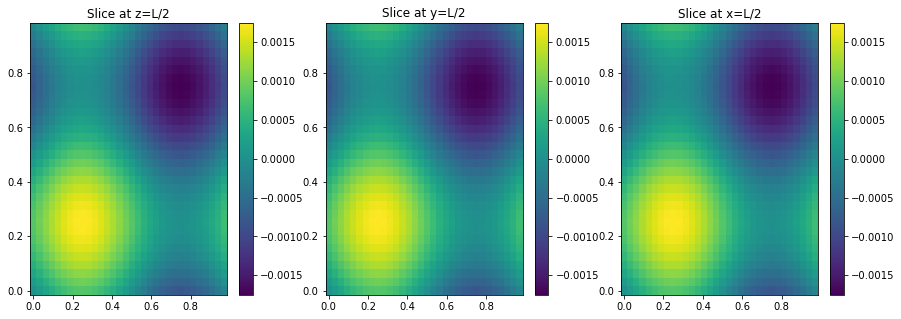

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import muFFT

# Define the 3D domain
num_steps = 100


dt = 1e-4

L = 1.0
N = 32
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
z = np.linspace(0, L, N, endpoint=False)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Define spherical heat sources and sinks
def spherical_heat_source_sink(X, Y, Z, L, radius=0.1):
    center_source = np.array([L/4, L/4, L/4])
    center_sink = np.array([3*L/4, 3*L/4, 3*L/4])
    source = np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_source) ** 2, axis=-1) / (2 * radius ** 2))
    sink = -np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_sink) ** 2, axis=-1) / (2 * radius ** 2))
    return source + sink

q_dot_S = spherical_heat_source_sink(X, Y, Z, L)

# Initialize muFFT
fft = muFFT.FFT((N, N, N), engine='pocketfft')

print(fft)

# Fourier transform of the heat source field
q_dot_S_hat = np.fft.fftn(q_dot_S,)

print(q_dot_S_hat.shape)

# Define the thermal diffusivity alpha
alpha = 1.0

# Solve for the Fourier coefficients of the temperature field
kx = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
ky = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
kz = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K2 = KX**2 + KY**2 + KZ**2


T_hat = q_dot_S_hat / (alpha * K2)
T_hat[0, 0, 0] = 0  # set the mean (DC component) to zero for simplicity

# Inverse Fourier transform to get the temperature field
# T = fft.backward(T_hat)
T = np.fft.ifftn(T_hat).real

for _ in range(num_steps):
    T_hat = np.fft.fftn(T)
    T_hat_new = T_hat / (1 + dt * alpha * K2)
    T = np.fft.ifftn(T_hat_new).real

# Plot slices through the 3D temperature field
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(x, y, T[:, :, N//2])
plt.colorbar()
plt.title('Slice at z=L/2')
plt.subplot(1, 3, 2)
plt.pcolormesh(x, z, T[:, N//2, :])
plt.colorbar()
plt.title('Slice at y=L/2')
plt.subplot(1, 3, 3)
plt.pcolormesh(y, z, T[N//2, :, :])
plt.colorbar()
plt.title('Slice at x=L/2')
plt.show()


In [5]:
%matplotlib inline
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import muFFT

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Define the 3D domain
L = 1.0
N = 32
local_N = N // size  # Assuming N is divisible by size
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, local_N, endpoint=False)
z = np.linspace(0, L, N, endpoint=False)
X, Y, Z = np.meshgrid(x, y + rank * local_N * (L / N), z, indexing='ij')

# Define spherical heat sources and sinks
def spherical_heat_source_sink(X, Y, Z, L, radius=0.1):
    center_source = np.array([L/4, L/4, L/4])
    center_sink = np.array([3*L/4, 3*L/4, 3*L/4])
    source = np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_source) ** 2, axis=-1) / (2 * radius ** 2))
    sink = -np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_sink) ** 2, axis=-1) / (2 * radius ** 2))
    return source + sink

q_dot_S = spherical_heat_source_sink(X, Y, Z, L)

# Initialize muFFT with MPI
fft = muFFT.FFT([N, N, N], dtype=np.float64, communicator=comm)

# Fourier transform of the heat source field
q_dot_S_hat = fft.forward(q_dot_S)

# Define the thermal diffusivity alpha
alpha = 1.0

# Solve for the Fourier coefficients of the temperature field
kx = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
ky = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
kz = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K2 = KX**2 + KY**2 + KZ**2

# Parallel computation: broadcast the K2 array to all processes
comm.Bcast(K2, root=0)

T_hat = q_dot_S_hat / (alpha * K2)
if rank == 0:
    T_hat[0, 0, 0] = 0  # set the mean (DC component) to zero for simplicity

# Inverse Fourier transform to get the temperature field
T = fft.backward(T_hat)

# Gather the temperature field on the root process
T_global = None
if rank == 0:
    T_global = np.empty([N, N, N], dtype=np.float64)
comm.Gather(T, T_global, root=0)

# Plot slices through the 3D temperature field if root
if rank == 0:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.pcolormesh(x, y, T_global[:, :, N//2])
    plt.colorbar()
    plt.title('Slice at z=L/2')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(x, z, T_global[:, N//2, :])
    plt.colorbar()
    plt.title('Slice at y=L/2')
    plt.subplot(1, 3, 3)
    plt.pcolormesh(y, z, T_global[N//2, :, :])
    plt.colorbar()
    plt.title('Slice at x=L/2')
    plt.show()



TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. _muFFT.PocketFFT(nb_grid_pts: List[int], communicator: _muGrid.Communicator = <_muGrid.Communicator object at 0x7f15b100ea30>, flags: _muFFT.FFT_PlanFlags = <FFT_PlanFlags.estimate: 0>, allow_temporary_buffer: bool = True, allow_destroy_input: bool = False)

Invoked with: [32, 32, 32], <_muGrid.Communicator object at 0x7f1604099470>; kwargs: dtype=<class 'numpy.float64'>

In [6]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import muFFT

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Define the 3D domain
L = 1.0
N = 32
local_N = N // size  # Assuming N is divisible by size
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, local_N, endpoint=False)
z = np.linspace(0, L, N, endpoint=False)
X, Y, Z = np.meshgrid(x, y + rank * local_N * (L / N), z, indexing='ij')

# Define spherical heat sources and sinks
def spherical_heat_source_sink(X, Y, Z, L, radius=0.1):
    center_source = np.array([L/4, L/4, L/4])
    center_sink = np.array([3*L/4, 3*L/4, 3*L/4])
    source = np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_source) ** 2, axis=-1) / (2 * radius ** 2))
    sink = -np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_sink) ** 2, axis=-1) / (2 * radius ** 2))
    return source + sink

q_dot_S = spherical_heat_source_sink(X, Y, Z, L)

# Initialize muFFT with MPI
fft = muFFT.FFT((N, N, N), dtype=np.float64, communicator=comm)

# Fourier transform of the heat source field
q_dot_S_hat = fft.forward(q_dot_S)

# Define the thermal diffusivity alpha
alpha = 1.0

# Solve for the Fourier coefficients of the temperature field
kx = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
ky = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
kz = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K2 = KX**2 + KY**2 + KZ**2

# Parallel computation: broadcast the K2 array to all processes
comm.Bcast(K2, root=0)

T_hat = q_dot_S_hat / (alpha * K2)
if rank == 0:
    T_hat[0, 0, 0] = 0  # set the mean (DC component) to zero for simplicity

# Inverse Fourier transform to get the temperature field
T = fft.backward(T_hat)

# Gather the temperature field on the root process
T_global = None
if rank == 0:
    T_global = np.empty([N, N, N], dtype=np.float64)
comm.Gather(T, T_global, root=0)

# Plot slices through the 3D temperature field if root
if rank == 0:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.pcolormesh(x, y, T_global[:, :, N//2])
    plt.colorbar()
    plt.title('Slice at z=L/2')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(x, z, T_global[:, N//2, :])
    plt.colorbar()
    plt.title('Slice at y=L/2')
    plt.subplot(1, 3, 3)
    plt.pcolormesh(y, z, T_global[N//2, :, :])
    plt.colorbar()
    plt.title('Slice at x=L/2')
    plt.show()


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. _muFFT.PocketFFT(nb_grid_pts: List[int], communicator: _muGrid.Communicator = <_muGrid.Communicator object at 0x7f15b100ea30>, flags: _muFFT.FFT_PlanFlags = <FFT_PlanFlags.estimate: 0>, allow_temporary_buffer: bool = True, allow_destroy_input: bool = False)

Invoked with: (32, 32, 32), <_muGrid.Communicator object at 0x7f15b0fb2830>; kwargs: dtype=<class 'numpy.float64'>